In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
import glob

sys.path.append('/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/utils/')
sys.path.append('/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/modeling/joint-clm-prosody/')

from config import *
# from src.data.prominence_regression_datamodule import ProminenceRegressionDataModule
# from src.models.joint_clm_prosody import ProsodyCausalLM

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /dartfs/rc/lab/F/FinnLab/tommy/models/token
Login successful


## Try transformers WhisperDecoder

In [2]:
from transformers import WhisperForCausalLM, WhisperForConditionalGeneration, WhisperProcessor
import torch
from datasets import load_dataset

processor = WhisperProcessor.from_pretrained("openai/whisper-large-v2")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-large-v2")

assistant_model = WhisperForCausalLM.from_pretrained("distil-whisper/distil-large-v2")

ds = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")

sample = ds[0]["audio"]
inputs = processor(
    sample["array"], sampling_rate=sample["sampling_rate"], return_tensors="pt",  return_attention_mask=True
) #.input_features

predicted_ids = model.generate(input_features, assistant_model=assistant_model)

transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]



/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/prosody/lib/python3.12/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


KeyboardInterrupt: 

In [35]:
from transformers import WhisperTokenizer

tokenizer = WhisperTokenizer.from_pretrained(
    "openai/whisper-small", 
    language="english", 
    bos_token=None,
    unk_token=None,
)

tokens = tokenizer(ds[0]['text'])
tokenizer.decode(tokens['input_ids'])

### Test EnCodec for audio tokenization

In [43]:
from argparse import ArgumentError
from typing import Optional, Tuple

import os, sys
import json
import random

from sklearn.model_selection import train_test_split
from pathlib import Path

from lightning import LightningDataModule
from transformers import AutoTokenizer, AutoModel, AutoModelForCTC


class AudioTextDataModule(LightningDataModule):
    def __init__(
        self,
        data_dir: str,
        audio_dir: str,
        textgrid_dir: str,
        batch_size: int = 64,
        num_workers: int = 0,
        pin_memory: bool = False,
        # model_name: str = None,
    ):
        super().__init__()
        self.data_dir = data_dir
        self.audio_dir = audio_dir
        self.textgrid_dir = textgrid_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.pin_memory = pin_memory
        self.model_name = model_name

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)

    def prepare_data(self):
        pass

    def setup(self, stage: Optional[str] = None):
        if stage == "fit":
            self.train_texts, self.val_texts, self.train_audio_tokens, self.val_audio_tokens = self._load_data("train")
        if stage == "test":
            self.test_texts, self.test_audio_tokens = self._load_data("test")

    def _load_data(self, split: str):
        texts = []
        audio_tokens = []
        split_dir = os.path.join(self.data_dir, split)
        for file_name in os.listdir(split_dir):
            textgrid_path = os.path.join(self.textgrid_dir, file_name.replace(".wav", ".TextGrid"))
            audio_path = os.path.join(self.audio_dir, file_name)
            words = parse_textgrid(textgrid_path)
            waveform, sample_rate = load_audio(audio_path)

            return words, waveform, sample_rate
            for word in words:
                segment = extract_word_segment(waveform, sample_rate, word["start_time"], word["end_time"])
                token = encode_segment(segment, self.model, self.feature_extractor)
                texts.append(word["text"])
                audio_tokens.append(token)
        return texts, audio_tokens

In [2]:
DATASET = 'gigaspeech'
split = 'test'
text_model_name = 'gpt2'
audio_model_name = 'wav2vec2'

file_paths = glob.glob(os.path.join(DATASETS_DIR, DATASET, 's/textgrids/test/', '*'))
file_name = os.path.basename(file_paths[0])

audio_dir = os.path.join(DATASETS_DIR, DATASET,  's/audio')
textgrid_dir = os.path.join(DATASETS_DIR, DATASET, 's/textgrids')
cache_dir = audio_dir.replace(DATASETS_DIR, SCRATCH_DIR)

textgrid_path = os.path.join(textgrid_dir, split, file_name.replace(".wav", ".TextGrid"))
audio_path = os.path.join(audio_dir, split, file_name.replace('.TextGrid', '.wav'))
# words = parse_textgrid(textgrid_path)
# waveform, sample_rate = load_audio(audio_path)

# # Audio tokenization process
# processor = AutoProcessor.from_pretrained(audio_models[audio_model_name])
# audio_model = AutoModel.from_pretrained(audio_models[audio_model_name])

# # Text tokenization process
# text_tokenizer = AutoTokenizer.from_pretrained(text_model_name)

In [4]:
%load_ext autoreload
%autoreload 2

from src.data.components.audio_text_dataset import AudioTextDataset

dataset = AudioTextDataset(audio_dir, textgrid_dir, cache_dir=cache_dir, split='test')


/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/prosody/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-large-960h-lv60 and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/prosody/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: 

In [10]:
dataset.__getitem__(0)

Error processing file /dartfs/rc/lab/F/FinnLab/datasets/gigaspeech/s/audio/test/YOU1000000102_S0000229.wav: Asking to pad but the tokenizer does not have a padding token. Please select a token to use as `pad_token` `(tokenizer.pad_token = tokenizer.eos_token e.g.)` or add a new pad token via `tokenizer.add_special_tokens({'pad_token': '[PAD]'})`.


In [6]:
from tqdm import tqdm

for i in tqdm(range(100)):
    x = dataset.__getitem__(i)

  0%|          | 0/100 [00:00<?, ?it/s]/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/modeling/joint-clm-prosody/src/data/audio_text_dataset.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relate

Loading from cache
Loading from cache
Loading from cache
Loading from cache
Loading from cache
Loading from cache
Loading from cache
Loading from cache
Loading from cache
Loading from cache
Loading from cache


 21%|██        | 21/100 [00:00<00:01, 65.11it/s]

Loading from cache
Loading from cache
Loading from cache
Loading from cache
Loading from cache
Loading from cache
Loading from cache
Loading from cache
Loading from cache
Loading from cache
Loading from cache


 35%|███▌      | 35/100 [00:00<00:01, 63.19it/s]

Loading from cache
Loading from cache
Loading from cache
Loading from cache
Loading from cache
Loading from cache
Loading from cache
Loading from cache
Loading from cache


 36%|███▌      | 36/100 [00:03<00:05, 11.83it/s]


NameError: name 'F' is not defined

In [343]:
x

107597

True

In [287]:
processor(segments, sampling_rate=sample_rate, padding=True, return_attention_mask=True, return_tensors="pt")

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [166]:
all_segments = []

text_tokens = text_tokenizer(word['text'], return_tensors='pt')

for word in words:

    ratios = torch.tensor([len(text_tokenizer.decode(x)) for x in text_tokens['input_ids'].T])
    ratios = ratios / ratios.sum()

    word_segments = extract_word_segment(waveform, sample_rate, word["start"], word["end"], ratios=ratios)
    all_segments.extend(word_segments)

In [223]:
text = ' '.join([word['text'] for word in words])
text_tokenizer = AutoTokenizer.from_pretrained(text_model_name,  use_fast=True) #add_prefix_space=True,

/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/prosody/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [259]:
# Tokenize the words
tokens = text_tokenizer(text)

# Find number of counts for each word (e.g., number of tokens each word is broken into)
word_ids, token_counts = np.unique(tokens.word_ids(), return_counts=True)

assert (len(word_ids) == len(words))

for word, idx, n_tokens in zip(words, word_ids, token_counts):

    # If there is more than one token, we need to divide the audio into segments
    if n_tokens > 1:
        ratios = torch.tensor([len(x) for x in text_tokenizer.batch_decode(tokens['input_ids'][idx:idx+n_tokens])])
        ratios = ratios / ratios.sum()
        word_segments = extract_word_segment(waveform, sample_rate, word["start"], word["end"], ratios=ratios)
    else:
        word_segments = extract_word_segment(waveform, sample_rate, word["start"], word["end"])

    all_segments.extend(word_segments)

In [275]:
def _process_inputs(words, waveform, sample_rate):

    # Join the words together into a sentence
    text = " ".join([word['text'] for word in words])

    # Tokenize the words
    text_tokens = text_tokenizer(text)

    # Find number of counts for each word (e.g., number of tokens each word is broken into)
    word_ids, token_counts = np.unique(text_tokens.word_ids(), return_counts=True)

    assert (len(word_ids) == len(words))

    segments = []
    
    # Ensure we get the right number of audio segments for each word (e.g., for each token)
    for word, idx, n_tokens in zip(words, word_ids, token_counts):

        # If there is more than one token, we need to divide the audio into segments
        if n_tokens > 1:
            ratios = torch.tensor([len(x) for x in text_tokenizer.batch_decode(text_tokens['input_ids'][idx:idx+n_tokens])])
            ratios = ratios / ratios.sum()
            word_segments = extract_word_segment(waveform, sample_rate, word["start"], word["end"], ratios=ratios)
        else:
            word_segments = extract_word_segment(waveform, sample_rate, word["start"], word["end"])

        segments.extend(word_segments)
    
    # Process all segments simultaneously
    features =  processor(segments, sampling_rate=sample_rate, padding=True, return_attention_mask=True, return_tensors="pt")

    with torch.no_grad():
        audio_inputs = audio_model(**features).last_hidden_state

    # Get the attention mask for the hidden states
    attention_mask = audio_model._get_feature_vector_attention_mask(
        audio_inputs.shape[1], 
        features['attention_mask']
    )

    # Perform pooling over the embeddings while accounting for attention mask
    audio_inputs = pool_embeddings(audio_inputs, attention_mask)

    data = {
        'text': text,
        'text_tokens': text_tokens['input_ids'],
        'text_attention_mask': text_tokens['attention_mask'],
        'audio_inputs': audio_inputs
    }

    return data

In [268]:
data = _process_inputs(words, waveform, sample_rate)

In [274]:
len(data['text_tokens'])

26

In [204]:
tokens.word_ids()

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24]

In [194]:
for x in tokens['offset_mapping']:
    print (text[slice(*x)])

dont
 let
 the
 noise
 of
 others
 opinions
 drown
 out
 your
 own
 inner
 voice
 and
 most
 important
 have
 the
 courage
 to
 follow
 your
 heart
 and
 intuition


### Run for padded

In [169]:
# segs = {'input_values': seg.squeeze() for seg in segments}
audio_model_name = "facebook/wav2vec2-large-960h-lv60"

processor = AutoProcessor.from_pretrained(audio_model_name)
audio_model = AutoModel.from_pretrained(audio_model_name)

# Pad the batch
padded_features = processor(all_segments, sampling_rate=sample_rate, padding=True, return_attention_mask=True, return_tensors="pt")
with torch.no_grad():
    outs = audio_model(**padded_features).last_hidden_state

attention_mask = audio_model._get_feature_vector_attention_mask(
    outs.shape[1], 
    padded_features['attention_mask']
)

x = pool_embeddings(outs, attention_mask)

/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/prosody/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-large-960h-lv60 and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [171]:
x.shape

torch.Size([34, 1024])

In [153]:
outs.last_hidden_state.shape[1]

17

In [155]:
attention_mask = audio_model._get_feature_vector_attention_mask(
    outs.last_hidden_state.shape[1], 
    padded_features['attention_mask']
)

In [159]:
x = pool_embeddings(outs.last_hidden_state, attention_mask)

In [56]:
torch.cosine_similarity(corrected_padded_features[0][:10], ctc_no_pad_features.hidden_states[-1])

tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]])

In [51]:
ctc_no_pad_features = processor(segments[:1], sampling_rate=sample_rate, padding=True, return_attention_mask=True, return_tensors="pt")

with torch.no_grad():
    ctc_no_pad_features = model(**ctc_no_pad_features, output_hidden_states=True) #.last_hidden_state

In [55]:
ctc_no_pad_features.hidden_states[-1]

tensor([[[ 0.0346, -0.1451,  0.1917,  ...,  0.1091, -0.0441,  0.1799],
         [ 0.0887, -0.0933,  0.1064,  ...,  0.1275, -0.0357,  0.2027],
         [-0.0149, -0.0881,  0.2005,  ...,  0.1454, -0.0135,  0.2051],
         ...,
         [-0.0071, -0.1177, -0.0245,  ...,  0.0899, -0.0504,  0.2034],
         [ 0.0589, -0.1012, -0.0130,  ...,  0.1264,  0.0095,  0.2047],
         [ 0.1115, -0.1436,  0.0245,  ...,  0.0926, -0.0243,  0.2036]]])

In [46]:
from transformers import AutoProcessor, Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h-lv60-self") #.to("cuda")


Some weights of the model checkpoint at facebook/wav2vec2-large-960h-lv60-self were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h-lv60-self and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.maske

In [23]:
no_pad_features.shape

torch.Size([1, 10, 768])

In [ ]:
padded_features[0]

torch.Size([17, 768])

In [131]:
test_features['attention_mask']

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)

In [120]:
aouts = audio_model(
    input_values=test_features['input_values'],
    attention_mask=test_features['attention_mask']
)

In [310]:
torch.cosine_similarity(a, b)

tensor([1.], grad_fn=<SumBackward1>)

In [309]:
idx = -1

a = pool_embeddings(all_inputs[idx])
b = pool_embeddings(outs.last_hidden_state[idx].unsqueeze(0), mask[idx].unsqueeze(0))

In [186]:
pool_embeddings(outs.last_hidden_state[0].unsqueeze(0))

tensor([[-2.3895e-02, -1.4980e-03,  3.9707e-03, -7.2643e-03, -3.9057e-02,
         -3.0495e-02, -3.4891e-03,  1.0340e-03, -4.5408e-02, -9.0956e-02,
          1.9611e-02, -8.6552e-03,  5.8443e-03,  7.4992e-03, -2.1662e-02,
          1.4769e-02, -5.9284e-02,  7.3311e-02, -7.4311e-04, -3.3417e-03,
         -4.0792e-02,  3.2262e-02, -1.4679e-03,  4.9121e-03,  1.8026e-02,
         -9.9176e-04, -7.1645e-02,  1.4925e-02, -2.7289e-03, -2.7383e-02,
          1.9971e-02, -1.8957e-03, -2.9088e-03, -1.8364e-02, -5.1769e-02,
          1.2695e-02,  5.3653e-02, -7.0116e-02, -2.1629e-02,  1.7895e-02,
         -2.2745e-02, -1.2971e-02, -2.0458e-02,  4.1952e-02, -3.3800e-02,
          2.4389e-02, -6.2728e-03,  5.2204e-03, -1.4331e-02,  2.2571e-03,
         -3.0958e-02, -9.7201e-03,  4.8494e-02, -5.4363e-03,  8.5382e-03,
         -9.4443e-03, -1.1127e-02, -1.0406e-01, -3.8229e-02, -2.1425e-02,
          2.8207e-02,  4.5051e-03,  5.3172e-03,  4.4611e-02, -3.5099e-03,
          1.8348e-02, -7.2146e-04, -4.

In [432]:
extract_features = audio_model.feature_extractor(test_features['input_values'])
extract_features = extract_features.transpose(1, 2)

mask = audio_model._get_feature_vector_attention_mask(extract_features.shape[1], attention_mask=test_features['attention_mask'])


        # if attention_mask is not None:
        #     # compute reduced attention_mask corresponding to feature vectors
        #     attention_mask = self._get_feature_vector_attention_mask(
        #         extract_features.shape[1], attention_mask, add_adapter=False
        #     )

hidden_states, extract_features = audio_model.feature_projection(extract_features)
# after_hidden_states = audio_model._mask_hidden_states(
#     hidden_states, mask_time_indices=None, attention_mask=mask
# )

# hidden_states[~mask] = 0

# encoder_outputs = audio_model.encoder(
#     hidden_states,
#     attention_mask=mask,
#     # output_attentions=output_attentions,
#     output_hidden_states=True,
#     # return_dict=return_dict,
# )

# make sure padded tokens output 0
expand_attention_mask = mask.unsqueeze(-1).repeat(1, 1, hidden_states.shape[2])
hidden_states[~expand_attention_mask] = 0

# extend attention_mask
attention_mask = 1.0 - mask[:, None, None, :].to(dtype=hidden_states.dtype)
attention_mask = attention_mask * torch.finfo(hidden_states.dtype).min
attention_mask = attention_mask.expand(
    attention_mask.shape[0], 1, attention_mask.shape[-1], attention_mask.shape[-1]
)


position_embeddings =  audio_model.encoder.pos_conv_embed(hidden_states)
_hidden_states =  _hidden_states + position_embeddings
_hidden_states =  audio_model.encoder.layer_norm(_hidden_states)
_hidden_states =  audio_model.encoder.dropout(_hidden_states)

# layer_outputs = audio_model.encoder.layers[0](
#     _hidden_states, attention_mask=attention_mask, output_attentions=False
# )

attn_residual = _hidden_states
_hidden_states = audio_model.encoder.layers[0].layer_norm(_hidden_states)
_hidden_states, attn_weights, _ = audio_model.encoder.layers[0].attention(
    _hidden_states, attention_mask=attention_mask, output_attentions=True
)


In [509]:
# make sure padded tokens output 0
expand_attention_mask = mask.unsqueeze(-1).repeat(1, 1, hidden_states.shape[2])
hidden_states[~expand_attention_mask] = 0

# extend attention_mask
attention_mask = 1.0 - mask[:, None, None, :].to(dtype=hidden_states.dtype)
# attention_mask = attention_mask * torch.finfo(hidden_states.dtype).min
attention_mask = attention_mask.expand(
    attention_mask.shape[0], 1, attention_mask.shape[-1], attention_mask.shape[-1]
)

In [489]:
# attention_mask = attention_mask * torch.finfo(hidden_states.dtype).min
# attention_mask = attention_mask.expand(
#     attention_mask.shape[0], 1, attention_mask.shape[-1], attention_mask.shape[-1]
# )

_attention_mask = (attention_mask[0].squeeze() + attention_mask[0].squeeze().T).to(bool).to(int).unsqueeze(0)

In [510]:
# _a = attention_mask.clone()

# _a[0, ...] = _attention_mask
# attention_mask = _a

attn_residual = _hidden_states
_hidden_states = audio_model.encoder.layers[0].layer_norm(_hidden_states)
_hidden_states, attn_weights, _ = audio_model.encoder.layers[0].attention(
    _hidden_states, attention_mask=attention_mask, output_attentions=True
)


In [512]:
_hidden_states[0]

tensor([[ 0.7889,  0.8587, -0.5937,  ...,  0.0753, -0.0205, -0.2947],
        [ 0.7889,  0.8587, -0.5937,  ...,  0.0753, -0.0205, -0.2947],
        [ 0.7889,  0.8587, -0.5937,  ...,  0.0753, -0.0205, -0.2947],
        ...,
        [ 0.7889,  0.8587, -0.5937,  ...,  0.0753, -0.0205, -0.2947],
        [ 0.7889,  0.8587, -0.5937,  ...,  0.0753, -0.0205, -0.2947],
        [ 0.7889,  0.8587, -0.5937,  ...,  0.0753, -0.0205, -0.2947]],
       grad_fn=<SelectBackward0>)

In [487]:
_attention_mask = (attention_mask[0].squeeze() + attention_mask[0].squeeze().T).to(bool).to(int).unsqueeze(0)

In [435]:
attention_mask[0]

tensor([[[-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
          -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
          -3.4028e+38, -3.4028e+38, -3.4028e+38, -3.4028e+38, -3.4028e+38,
          -3.4028e+38, -3.4028e+38],
         [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
          -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
          -3.4028e+38, -3.4028e+38, -3.4028e+38, -3.4028e+38, -3.4028e+38,
          -3.4028e+38, -3.4028e+38],
         [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
          -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
          -3.4028e+38, -3.4028e+38, -3.4028e+38, -3.4028e+38, -3.4028e+38,
          -3.4028e+38, -3.4028e+38],
         [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
          -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
          -3.4028e+38, -3.4028e+38, -3.4028e+38, -3.4028e+38, -3

In [378]:
from matplotlib import pyplot as plt

In [388]:
attention_mask.shape

torch.Size([3, 1, 17, 17])

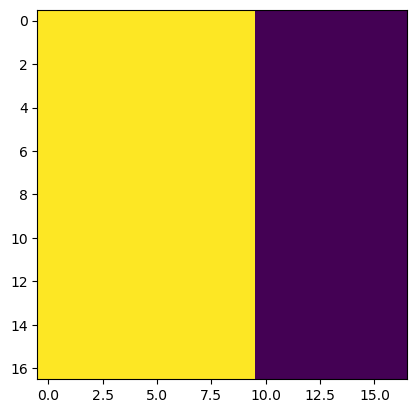

In [383]:
plt.imshow(attention_mask[0].squeeze().numpy())

In [358]:
attention_mask[0]

tensor([[[-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
          -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
          -3.4028e+38, -3.4028e+38, -3.4028e+38, -3.4028e+38, -3.4028e+38,
          -3.4028e+38, -3.4028e+38],
         [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
          -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
          -3.4028e+38, -3.4028e+38, -3.4028e+38, -3.4028e+38, -3.4028e+38,
          -3.4028e+38, -3.4028e+38],
         [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
          -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
          -3.4028e+38, -3.4028e+38, -3.4028e+38, -3.4028e+38, -3.4028e+38,
          -3.4028e+38, -3.4028e+38],
         [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
          -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
          -3.4028e+38, -3.4028e+38, -3.4028e+38, -3.4028e+38, -3

In [354]:
layer_outputs[0][0]

tensor([[-0.0447, -0.1186,  0.0409,  ...,  0.1667, -0.0485,  0.0605],
        [ 0.0456, -0.0441, -0.0076,  ...,  0.0680,  0.1726,  0.0995],
        [ 0.0176,  0.1331,  0.0335,  ...,  0.4063,  0.1755,  0.0937],
        ...,
        [-0.1121,  0.0705, -0.0606,  ...,  0.0290, -0.0559, -0.0230],
        [-0.1271,  0.0769, -0.0588,  ..., -0.0027, -0.0642, -0.0341],
        [-0.1330,  0.0814, -0.0562,  ...,  0.0008, -0.0752, -0.0340]],
       grad_fn=<SelectBackward0>)

In [349]:
hidden_states[0]

tensor([[-0.0207, -1.3331,  1.2335,  ..., -1.0619,  2.0371, -0.2729],
        [-0.0242, -0.0481, -0.3385,  ..., -0.9398,  1.3715,  0.3472],
        [ 0.3132,  0.4043, -1.3884,  ..., -0.0910, -0.8634, -1.2256],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       grad_fn=<SelectBackward0>)

In [332]:
_hidden_states[0]

tensor([[ 0.2429, -0.6389,  0.2645,  ..., -0.4481,  0.5589, -0.2960],
        [ 0.1344, -0.0145, -0.2479,  ..., -0.3855,  0.3618, -0.1929],
        [ 0.0114,  0.2874, -0.5432,  ...,  0.1727, -0.2483, -0.6027],
        ...,
        [-0.1991, -0.3136, -0.1565,  ..., -0.6363,  0.4043,  0.1371],
        [-0.2154, -0.3062, -0.1447,  ..., -0.6598,  0.3813,  0.1274],
        [-0.2099, -0.3123, -0.1377,  ..., -0.6847,  0.3718,  0.1461]],
       grad_fn=<SelectBackward0>)

In [327]:
encoder_outputs['hidden_states'][1][0]

tensor([[ 0.1368,  0.0256,  0.1614,  ..., -0.0743, -0.0048,  0.1566],
        [-0.0478, -0.1585, -0.2020,  ..., -0.1940,  0.0892,  0.0094],
        [-0.1805, -0.0529, -0.0556,  ...,  0.2473, -0.1219,  0.0157],
        ...,
        [ 0.0637, -0.0274,  0.1209,  ...,  0.0385, -0.0625,  0.1091],
        [ 0.0123,  0.0546,  0.1353,  ..., -0.0351, -0.0912,  0.1180],
        [ 0.0013,  0.0770,  0.1722,  ..., -0.0349, -0.1282,  0.1358]],
       grad_fn=<SelectBackward0>)

In [225]:
torch.cosine_similarity(after_hidden_states[0], hidden_states[0])

torch.Size([17])

In [303]:
all_inputs =[]

for segment in segments:

    features = processor(segment, sampling_rate=sample_rate, padding=True, return_attention_mask=True, return_tensors="pt")
    with torch.no_grad():
        inputs = audio_model(**features).last_hidden_state
    all_inputs.append(inputs)
    # sys.exit(0)

In [109]:
test_inputs[0].mean(0)

tensor([-1.0586e-01, -6.6365e-03,  1.7591e-02, -3.2182e-02, -1.7303e-01,
        -1.3510e-01, -1.5457e-02,  4.5807e-03, -2.0117e-01, -4.0295e-01,
         8.6880e-02, -3.8345e-02,  2.5892e-02,  3.3223e-02, -9.5970e-02,
         6.5432e-02, -2.6264e-01,  3.2479e-01, -3.2922e-03, -1.4804e-02,
        -1.8072e-01,  1.4293e-01, -6.5033e-03,  2.1762e-02,  7.9860e-02,
        -4.3937e-03, -3.1740e-01,  6.6120e-02, -1.2090e-02, -1.2131e-01,
         8.8478e-02, -8.3982e-03, -1.2887e-02, -8.1358e-02, -2.2935e-01,
         5.6241e-02,  2.3770e-01, -3.1063e-01, -9.5822e-02,  7.9279e-02,
        -1.0077e-01, -5.7464e-02, -9.0634e-02,  1.8586e-01, -1.4974e-01,
         1.0805e-01, -2.7790e-02,  2.3128e-02, -6.3490e-02,  9.9996e-03,
        -1.3715e-01, -4.3062e-02,  2.1484e-01, -2.4084e-02,  3.7826e-02,
        -4.1840e-02, -4.9293e-02, -4.6099e-01, -1.6936e-01, -9.4916e-02,
         1.2496e-01,  1.9959e-02,  2.3556e-02,  1.9764e-01, -1.5550e-02,
         8.1286e-02, -3.1963e-03, -2.1078e-02, -8.6

In [112]:
inputs.mean(0).mean(0)

tensor([-8.4595e-02, -3.6891e-02, -7.3343e-02, -6.7418e-02, -8.4808e-02,
        -1.5854e-01, -5.1389e-02, -1.4615e-02, -1.0109e-01, -3.7211e-01,
         1.2793e-01, -1.4080e-01,  7.3992e-02,  4.0280e-02,  9.1792e-02,
         7.2573e-02, -3.1303e-01,  3.4526e-01,  6.2650e-03,  5.0196e-02,
        -2.4824e-01,  1.1582e-01,  2.2362e-01,  2.6775e-02,  1.0136e-01,
         1.6513e-02, -4.9735e-01,  1.1437e-01, -3.0881e-02, -1.1575e-01,
         1.2703e-01, -6.0878e-03,  2.2107e-02, -8.6003e-02, -3.1766e-01,
         1.6566e-01,  2.0838e-01, -2.5917e-01, -1.4243e-01,  1.2489e-01,
        -1.5440e-01, -8.4106e-02, -1.3576e-01,  1.8271e-01, -2.2669e-01,
         4.9862e-02, -6.2690e-03,  3.3725e-02, -4.4198e-02,  4.2136e-03,
        -1.1800e-01,  3.0094e-04,  3.3288e-01,  7.6247e-03,  4.6592e-02,
        -5.3745e-02, -1.5765e-02, -4.4887e-01, -1.6056e-01, -3.9075e-02,
         1.1434e-01,  5.8828e-02,  2.2339e-02,  2.6648e-01, -2.0229e-02,
         1.1905e-01,  1.5379e-03, -7.4630e-03, -1.2

In [83]:
test = audio_model(**features, return_dict=True)

In [86]:
inputs

Wav2Vec2BaseModelOutput(last_hidden_state=tensor([[[-1.1868e-01,  1.7360e-02, -1.1886e-02,  ..., -1.4341e-01,
           2.7844e-02,  1.1457e-01],
         [-1.1999e-01, -2.0933e-03,  5.6863e-02,  ..., -8.5153e-02,
           2.2196e-02,  8.1948e-02],
         [-1.0305e-01, -1.0361e-02,  4.8652e-02,  ..., -6.5978e-02,
           1.2478e-02,  4.5145e-02],
         ...,
         [-1.0591e-01, -8.3574e-03,  4.7337e-02,  ..., -6.9505e-02,
           1.2614e-02,  4.8834e-02],
         [-1.0595e-01, -8.3057e-03,  4.7186e-02,  ..., -6.9616e-02,
           1.2679e-02,  4.9047e-02],
         [-1.0612e-01, -8.1272e-03,  4.7287e-02,  ..., -6.9831e-02,
           1.2708e-02,  4.9323e-02]],

        [[-1.0334e-01, -6.0915e-02,  3.9164e-02,  ..., -1.8516e-01,
          -8.8118e-03, -1.2711e-02],
         [-9.4939e-02, -6.2241e-02,  4.3321e-02,  ..., -1.8774e-01,
          -1.7906e-02, -1.7977e-02],
         [-9.1639e-02, -6.0596e-02,  3.9384e-02,  ..., -1.8169e-01,
          -1.3518e-02, -1.6702e-02

In [69]:
segments[0].shape

[array([ 0.00631714,  0.00939941,  0.01229858, ..., -0.01464844,
        -0.04824829, -0.02145386], dtype=float32),
 array([-0.00143433,  0.01113892,  0.01596069, ..., -0.16726685,
        -0.16769409, -0.16738892], dtype=float32),
 array([-0.16616821, -0.16699219, -0.16567993, ...,  0.00582886,
         0.00445557,  0.00680542], dtype=float32)]

(3360,)

In [68]:
inputs['extract_features'].shape

torch.Size([3, 17, 512])

In [493]:
dataset = AudioTextDataset(audio_dir, textgrid_dir, split='test')
inputs = dataset._process_inputs(words, waveform, sample_rate)

/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/prosody/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [448]:
file_name = os.path.basename(file_paths[0])

textgrid_path = os.path.join(textgrid_dir, split, file_name.replace(".wav", ".TextGrid"))
audio_path = os.path.join(audio_dir, split, file_name.replace('.TextGrid', '.wav'))
words = parse_textgrid(textgrid_path)
waveform, sample_rate = load_audio(audio_path)

In [9]:
DATASET = 'gigaspeech'

file_paths = glob.glob(os.path.join(DATASETS_DIR, DATASET, 's/textgrids/test/', '*'))
# os.path.join()

In [28]:
tg = parse_textgrid(file_paths[0])

In [169]:
from transformers import AutoTokenizer, AutoFeatureExtractor, AutoModelForCTC, AutoModel
import torch

# import model, feature extractor, tokenizer
model = AutoModel.from_pretrained("facebook/wav2vec2-base-960h")
tokenizer = AutoTokenizer.from_pretrained("facebook/wav2vec2-base-960h")
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base-960h")



Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/prosody/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [170]:
input_values = feature_extractor(segment.squeeze(), return_tensors="pt").input_values
outputs = model(input_values) #.logits[0]
pooled_state = pool_embeddings(outputs.last_hidden_state)

inputs = processor(raw_audio=audio_sample, sampling_rate=processor.sampling_rate, return_tensors="pt")


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


### Use EnCodec

In [56]:
from datasets import load_dataset, Audio
from transformers import EncodecModel, AutoProcessor
librispeech_dummy = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")

model = EncodecModel.from_pretrained("facebook/encodec_24khz")
processor = AutoProcessor.from_pretrained("facebook/encodec_24khz")
librispeech_dummy = librispeech_dummy.cast_column("audio", Audio(sampling_rate=processor.sampling_rate))
audio_sample = librispeech_dummy[-1]["audio"]["array"]
inputs = processor(raw_audio=audio_sample, sampling_rate=processor.sampling_rate, return_tensors="pt")

encoder_outputs = model.encode(inputs["input_values"], inputs["padding_mask"])

/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/prosody/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/prosody/lib/python3.12/site-packages/transformers/models/encodec/modeling_encodec.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("padding_total", torch.tensor(kernel_size - stride, dtype=torch.int64), persistent=False)


## Create PyTorch Lightning DataModule --> similar to pt dataloader

In [2]:
modeling_dir = os.path.join(BASE_DIR, 'code/modeling/joint-clm-prosody')

data_module = ProminenceRegressionDataModule(
    dataset_name = 'helsinki_prominence',
    data_dir = os.path.join(modeling_dir, 'data/heglsinki-prosody/data'),
    train_file = 'train_360.txt',
    val_file = 'dev.txt',
    test_file = 'test.txt',
    model_name = "gpt2",
    batch_size=32,
)

data_module.setup(stage="fit")

# for batch in data_module.train_dataloader():
#     sys.exit(0)

Using GPT2 tokenizer


/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/prosody/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Dataloader: padding with token id: 50256
Loading data from /dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/modeling/joint-clm-prosody/data/helsinki-prosody/data


Preprocessing samples: 100%|██████████| 109791/109791 [01:19<00:00, 1374.29it/s]


Failed 7217/109791


Preprocessing samples: 100%|██████████| 12199/12199 [00:08<00:00, 1462.63it/s]


Failed 768/12199


### Get all batches

In [4]:
import torch
from matplotlib import pyplot as plt
import seaborn as sns

In [5]:
all_labels = []

for batch in data_module.train_dataloader():
    all_labels.append(batch['tokenized_labels'].flatten())
all_labels = torch.concatenate(all_labels)

## Model code

In [11]:
import torch
from torch import nn
from torch.distributions.gamma import Gamma
from torch.distributions.normal import Normal
from torch.nn import functional as F

In [39]:
model = ProsodyCausalLM(model_name="gpt2", pretrained=True)
# outputs = test.forward(batch)

Loading Huggingface model.
Loading pretrained model
Using joint loss


In [5]:
loss, outputs = model.step(batch)

In [15]:
dist = Normal(outputs['mu'], outputs['var'].squeeze(-1))

In [6]:
logits, labels, mask = model.get_shifted_labels(
    logits=outputs['logits'],
    labels=batch['input_ids'],
    mask=batch['attention_mask']
)

# logits = outputs['logits']
# labels=batch['input_ids']
# mask=batch['attention_mask']

In [7]:
preds = torch.argmax(logits, -1)
correct = (preds == labels) * mask.bool()

correct = torch.sum(correct)
total = torch.sum(mask)

In [14]:
dist = outputs['dist']

In [35]:
# prosody labels
labels = batch['tokenized_labels']
dist = outputs['dist']

loss_mask = batch['loss_mask']

mu = outputs['mu']
var = outputs['var'].squeeze(-1)

In [70]:
from torch.distributions.gamma import Gamma

shifted_labels = labels[..., 1:].contiguous().view(-1)
shifted_mu = mu[..., :-1].contiguous() #.view(-1)
shifted_var = var[..., :-1].contiguous()#. view(-1)
shifted_mask = loss_mask[..., 1:].contiguous().view(-1)

dist = Gamma(shifted_mu, shifted_var)

In [83]:
batch['tokenized_labels']

tensor([[ 1.9840e+00, -9.9900e+02,  1.1410e+00,  ..., -1.0000e+00,
         -1.0000e+00, -1.0000e+00],
        [ 1.8000e-02,  2.0110e+00, -9.9900e+02,  ..., -1.0000e+00,
         -1.0000e+00, -1.0000e+00],
        [ 2.1030e+00,  2.2330e+00,  7.1000e-01,  ..., -1.0000e+00,
         -1.0000e+00, -1.0000e+00],
        ...,
        [ 1.4910e+00,  1.4910e+00,  1.9500e-01,  ..., -1.0000e+00,
         -1.0000e+00, -1.0000e+00],
        [ 2.4880e+00, -9.9900e+02,  1.0660e+00,  ..., -1.0000e+00,
         -1.0000e+00, -1.0000e+00],
        [-9.9900e+02, -9.9900e+02,  9.9400e-01,  ..., -1.0000e+00,
         -1.0000e+00, -1.0000e+00]])

In [85]:
batch['input_text']

['Then , across the pale glimmering of sand , Henriot saw a figure moving .',
 'The captain , who had so long been a cause of so much discomfort , was gone where the wicked cease from troubling .',
 'This first book of his brought him into notice , and served as an introduction to Tycho and to Galileo .',
 "Here's what I found at the very site of that final shipwreck !",
 'They stopped and stared at me .',
 "'Oh , indeed ! ' said mrs Rogers graciously ; for she was the lodger , and her servant was in waiting , so she was more gracious than intimate , in right of her position .",
 "Well , what of it ? It's not my fault . And he began thinking about the next day .",
 'Let us seek David on the hillsides , tending his flocks with loving care .',
 'But he heard a rustling in the branches , and a golden apple fell into his hand .',
 'So , comrades , said Myles at last , what shall we do now ?',
 'To acquire languages , departed or living in spite of such obstinacies as he now knew them inher

In [82]:
batch['original_labels']

[[1.984,
  None,
  1.141,
  0.0,
  1.745,
  0.858,
  0.003,
  1.229,
  None,
  1.309,
  0.596,
  0.07,
  0.954,
  0.57,
  None],
 [0.018,
  2.011,
  None,
  0.061,
  0.587,
  1.907,
  0.867,
  0.47,
  0.067,
  1.827,
  0.037,
  1.096,
  0.189,
  1.041,
  None,
  0.545,
  1.721,
  0.12,
  0.034,
  1.686,
  1.96,
  0.898,
  0.183,
  None],
 [2.103,
  2.233,
  0.71,
  0.112,
  0.866,
  1.541,
  0.603,
  0.056,
  0.842,
  None,
  0.195,
  2.098,
  0.113,
  0.029,
  1.691,
  0.044,
  1.588,
  0.212,
  0.018,
  0.718,
  None],
 [0.424,
  0.033,
  0.29,
  2.272,
  0.028,
  0.0,
  1.688,
  0.823,
  0.086,
  0.33,
  1.032,
  0.605,
  None],
 [0.508, 2.466, 0.003, 1.42, 0.0, 0.301, None],
 [None,
  None,
  2.403,
  None,
  None,
  4.155,
  0.32,
  0.487,
  0.404,
  None,
  0.971,
  0.165,
  1.14,
  0.145,
  0.0,
  None,
  1.249,
  0.465,
  0.0,
  2.27,
  0.562,
  0.0,
  None,
  1.075,
  0.351,
  0.75,
  0.026,
  0.293,
  1.181,
  0.008,
  None,
  0.789,
  0.282,
  0.725,
  0.012,
  0.072,
  None

In [79]:
batch.keys()

dict_keys(['input_text', 'tokenized_text', 'original_labels', 'tokenized_labels', 'input_ids', 'loss_mask', 'attention_mask', 'word_to_tokens'])

In [56]:
shifted_labels = shifted_labels * shifted_mask + 1e-4  # add small constant for numerical stability

In [60]:
nll = -dist.log_prob(shifted_labels)

In [61]:
masked_nll = nll * shifted_mask

In [65]:
loss = masked_nll.sum() / shifted_mask.sum()

In [66]:
loss

tensor(1.1118, grad_fn=<DivBackward0>)

In [42]:
shifted_mu

tensor([0.6996, 0.0008, 0.4233,  ..., 0.4181, 0.4164, 0.4170],
       grad_fn=<ViewBackward0>)

In [23]:
labels = labels * loss_mask + 1e-4  # add small constant for numerical stability
nll = -dist.log_prob(labels)

# mask loss
masked_nll = nll * loss_mask
masked_nll_mean = masked_nll.sum() / loss_mask.sum()

In [34]:
masked_nll

tensor([[ 2.1053, -0.0000,  1.6620,  ..., -0.0000, -0.0000, -0.0000],
        [-0.8416,  2.1437, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
        [ 2.2663,  3.1142,  1.2448,  ..., -0.0000, -0.0000, -0.0000],
        ...,
        [ 1.4299,  1.6123,  1.0655,  ..., -0.0000, -0.0000, -0.0000],
        [ 2.4956, -0.0000,  3.3014,  ..., -0.0000, -0.0000, -0.0000],
        [-0.0000, -0.0000,  1.9905,  ..., -0.0000, -0.0000, -0.0000]],
       grad_fn=<MulBackward0>)

In [65]:
batch['loss_mask'].shape

torch.Size([32, 43])

In [62]:
outputs['var'].view(-1).contiguous()

tensor([1.4254, 5.9616, 3.6534,  ..., 1.2453, 1.2425, 1.2350],
       grad_fn=<ViewBackward0>)

In [112]:
print(5e-5 == 0.00005)

True


In [105]:
outputs['prosody_loss']

tensor(7.1849, grad_fn=<DivBackward0>)

### Manually perform forward pass

In [83]:
# tokenized labels = prosody values
input_embeds = test.get_input_embeddings(
    input_ids = batch['input_ids'], 
    prosody_values = batch['tokenized_labels']
)

# get outputs from causal LM
outputs = test.model.transformer(
    inputs_embeds=input_embeds, 
    attention_mask=batch["attention_mask"], 
)

# get the logits for predicting each item in the sequence
logits = test.model.lm_head(outputs.last_hidden_state)

# get prosody predictions
preds = test.regressor(outputs.last_hidden_state)

### Get distribution over the predictions

In [84]:
# split last dimension into mu and var
mu, var = torch.chunk(preds, chunks=2, dim=-1)

# ensure positivity of var + add a small constant for numerical stability
var = F.softplus(var)
var = (var + eps).squeeze(-1)

# have to squeeze the last dimension due to chunking
if test.output_activation is not None:
    mu = test.output_activation(mu.squeeze(-1))

# Gamma distribution with concentration mu and rate var
mu = F.softplus(mu)
dist = Gamma(mu, var)
preds = dist.mean

## Test natural output

In [100]:
test.prosody_loss(batch, outputs)

tensor(1.0272, grad_fn=<DivBackward0>)

In [94]:
# prosody labels
labels = batch['tokenized_labels']
dist = outputs['dist']
loss_mask = batch["loss_mask"]  # ignore padded sequence in loss



# log likelihood of labels given the distribution
labels = labels * loss_mask + 1e-4  # add small constant for numerical stability
nll = -dist.log_prob(labels)

# mask loss
masked_nll = nll * loss_mask
masked_nll_mean = masked_nll.sum() / loss_mask.sum()


In [95]:
masked_nll_mean

tensor(4.5416, grad_fn=<DivBackward0>)

## Test PEFT

In [21]:
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType

In [584]:
lora_config = LoraConfig(
    r=16,
    lora_alpha=16,
    lora_dropout=0.1,
    task_type="CAUSAL_LM"
)

In [28]:
lora_config = {
    'r': 16,
    'lora_alpha': 32,
    'lora_dropout': 0.05,
    'bias': "none",
    'task_type': "CAUSAL_LM",
    'base_model_name_or_path': 'gpt2',
    'modules_to_save': []
}

In [27]:
config = LoraConfig(**lora_config)
model = get_peft_model(test.model, config)

model.print_trainable_parameters()

trainable params: 39,187,200 || all params: 163,627,008 || trainable%: 23.9491


In [587]:
# # peft
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    base_model_name_or_path=model_name,
    # modules_to_save=["wte", "lm_head"]
)

model = get_peft_model(test.model, config)

In [576]:
# model_name = "gpt2"

# # loading base model and resizing embedding layers
# model = AutoModelForCausalLM.from_pretrained(model_name)

# # gradient checkpointing enabling
# model.enable_input_require_grads()
# model.gradient_checkpointing_enable()


# # peft
# config = LoraConfig(
#     r=16,
#     lora_alpha=32,
#     lora_dropout=0.05,
#     bias="none",
#     task_type="CAUSAL_LM",
#     base_model_name_or_path=model_name,
#     modules_to_save=["wte"] 
# )

# model = get_peft_model(model, config)

# model.print_trainable_parameters()

/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/prosody/lib/python3.10/site-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [591]:
# Inspect the trainable parameters
for name, param in test.named_parameters():
    if param.requires_grad:
        print(f"Trainable layer: {name}")
    else:
        print(f"Non-trainable layer: {name}")

Non-trainable layer: model.transformer.wte.weight
Non-trainable layer: model.transformer.wpe.weight
Non-trainable layer: model.transformer.h.0.ln_1.weight
Non-trainable layer: model.transformer.h.0.ln_1.bias
Non-trainable layer: model.transformer.h.0.attn.c_attn.base_layer.weight
Non-trainable layer: model.transformer.h.0.attn.c_attn.base_layer.bias
Trainable layer: model.transformer.h.0.attn.c_attn.lora_A.default.weight
Trainable layer: model.transformer.h.0.attn.c_attn.lora_B.default.weight
Non-trainable layer: model.transformer.h.0.attn.c_proj.weight
Non-trainable layer: model.transformer.h.0.attn.c_proj.bias
Non-trainable layer: model.transformer.h.0.ln_2.weight
Non-trainable layer: model.transformer.h.0.ln_2.bias
Non-trainable layer: model.transformer.h.0.mlp.c_fc.weight
Non-trainable layer: model.transformer.h.0.mlp.c_fc.bias
Non-trainable layer: model.transformer.h.0.mlp.c_proj.weight
Non-trainable layer: model.transformer.h.0.mlp.c_proj.bias
Non-trainable layer: model.transform

In [421]:
for name, param in test.model.named_parameters():
    print (name)

transformer.wte.weight
transformer.wpe.weight
transformer.h.0.ln_1.weight
transformer.h.0.ln_1.bias
transformer.h.0.attn.c_attn.base_layer.weight
transformer.h.0.attn.c_attn.base_layer.bias
transformer.h.0.attn.c_attn.lora_A.default.weight
transformer.h.0.attn.c_attn.lora_B.default.weight
transformer.h.0.attn.c_proj.weight
transformer.h.0.attn.c_proj.bias
transformer.h.0.ln_2.weight
transformer.h.0.ln_2.bias
transformer.h.0.mlp.c_fc.weight
transformer.h.0.mlp.c_fc.bias
transformer.h.0.mlp.c_proj.weight
transformer.h.0.mlp.c_proj.bias
transformer.h.1.ln_1.weight
transformer.h.1.ln_1.bias
transformer.h.1.attn.c_attn.base_layer.weight
transformer.h.1.attn.c_attn.base_layer.bias
transformer.h.1.attn.c_attn.lora_A.default.weight
transformer.h.1.attn.c_attn.lora_B.default.weight
transformer.h.1.attn.c_proj.weight
transformer.h.1.attn.c_proj.bias
transformer.h.1.ln_2.weight
transformer.h.1.ln_2.bias
transformer.h.1.mlp.c_fc.weight
transformer.h.1.mlp.c_fc.bias
transformer.h.1.mlp.c_proj.weigh

In [408]:
for layer in test.model.layers:
    if layer.trainable:
        print (layer.name)

AttributeError: 'GPT2LMHeadModel' object has no attribute 'layers'

In [394]:
TaskType.FEATURE_EXTRACTION

<TaskType.FEATURE_EXTRACTION: 'FEATURE_EXTRACTION'>

In [181]:
inputs = ['This is a']
# inputs = [f'{ins} {tokenizer.mask_token}' for ins in inputs]

inputs = tokenizer(inputs, return_tensors="pt")
# outputs = model(**inputs, output_hidden_states=True)